In [1]:
import torch
import os
import matplotlib.pyplot as plt
from data._utils import load_Flavell2023, load_Uzel2022
from train._utils import model_predict, make_predictions
from visualization._utils import plot_targets_predictions, plot_correlation_scatterplot
from models._utils import *

In [2]:
PATH = "../logs/hydra/2023_04_04_20_14_15/0/checkpoints/9_epochs_837_worms.pt"
checkpoint = torch.load(PATH)
for key in checkpoint.keys():
    print(key)

epoch
loss
dataset_name
model_name
optimizer_name
learning_rate
timestamp
covered_neurons
input_size
hidden_size
num_layers
num_cohorts
num_worms
model_state_dict
optimizer_state_dict


In [3]:
model_name = checkpoint["model_name"]
input_size = checkpoint["input_size"]
hidden_size = checkpoint["hidden_size"]
model_state_dict = checkpoint["model_state_dict"]
optimizer_state_dict = checkpoint["optimizer_state_dict"]
num_layers = 1 #checkpoint["num_layers"]
epoch = checkpoint["epoch"]

In [4]:
model = eval(model_name)(input_size, hidden_size, num_layers)
model.load_state_dict(model_state_dict)
model.eval()

NeuralCFC(
  (rnn): CfC(
    (rnn_cell): WiredCfCCell(
      (layer_0): CfCCell(
        (tanh): Tanh()
        (sigmoid): Sigmoid()
        (ff1): Linear(in_features=379, out_features=77, bias=True)
        (ff2): Linear(in_features=379, out_features=77, bias=True)
        (time_a): Linear(in_features=379, out_features=77, bias=True)
        (time_b): Linear(in_features=379, out_features=77, bias=True)
      )
      (layer_1): CfCCell(
        (tanh): Tanh()
        (sigmoid): Sigmoid()
        (ff1): Linear(in_features=128, out_features=51, bias=True)
        (ff2): Linear(in_features=128, out_features=51, bias=True)
        (time_a): Linear(in_features=128, out_features=51, bias=True)
        (time_b): Linear(in_features=128, out_features=51, bias=True)
      )
      (layer_2): CfCCell(
        (tanh): Tanh()
        (sigmoid): Sigmoid()
        (ff1): Linear(in_features=179, out_features=128, bias=True)
        (ff2): Linear(in_features=179, out_features=128, bias=True)
        (ti

In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0) # turn off learning
optimizer.load_state_dict(optimizer_state_dict)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [6]:
# dataset = load_Flavell2023() # dataset of multiple worms
dataset = load_Uzel2022() # dataset of multiple worms
for key in dataset["worm0"].keys():
    print(key)
named_neurons_mask = dataset["worm0"]["named_neurons_mask"]
calcium_data = dataset["worm0"]["calcium_data"]
time_in_seconds = dataset["worm0"]["time_in_seconds"]
max_time = dataset["worm0"]["max_time"]

dataset
worm
calcium_data
smooth_calcium_data
residual_calcium
smooth_residual_calcium
neuron_to_idx
idx_to_neuron
max_time
time_in_seconds
dt
num_neurons
num_named_neurons
num_unknown_neurons
named_neurons_mask
unknown_neurons_mask
neurons_mask
named_neuron_to_idx
idx_to_named_neuron
unknown_neuron_to_idx
idx_to_unknown_neuron
slot_to_named_neuron
named_neuron_to_slot
slot_to_unknown_neuron
unknown_neuron_to_slot
slot_to_neuron
neuron_to_slot


In [7]:
named_neuron_inds = torch.where(named_neurons_mask)[0]
print(named_neuron_inds)
nidx = named_neuron_inds[0].item() # pick a neuron to plot
print(nidx)

tensor([ 12,  13,  22,  25,  26,  29,  49,  50,  53,  54,  55,  56,  59,  60,
         61,  62,  88,  94,  96,  97,  98, 103, 110, 112, 157, 162, 177, 178,
        189, 190, 193, 200, 204, 206, 213, 214, 216, 227, 228, 229, 232, 233,
        234, 235, 244, 245, 247, 256, 257, 258, 259, 260, 262, 263, 272, 274,
        275, 293])
12


In [18]:
tau_out = 1
targets, predictions = model_predict(model, calcium_data[:max_time//2, :] * named_neurons_mask, tau=tau_out)
print(targets.shape, predictions.shape)

torch.Size([1656, 302]) torch.Size([1656, 302])


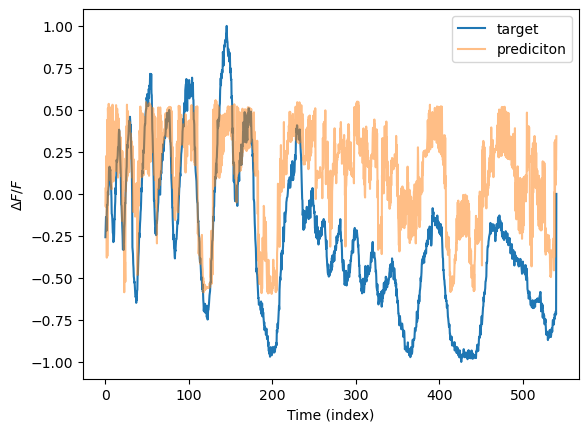

In [19]:
plt.plot(time_in_seconds[tau_out:tau_out + max_time//2], targets[:, nidx], label="target")
plt.plot(time_in_seconds[tau_out:tau_out + max_time//2], predictions[:, nidx], label="prediciton", alpha=0.5)
plt.legend()
plt.xlabel("Time (index)")
plt.ylabel("$\Delta F / F$")
plt.show()

In [75]:
make_predictions(model, dataset, log_dir=os.getcwd(), tau=1)

In [76]:
plot_targets_predictions(log_dir=os.getcwd(), worm="all", neuron="AVAL")

In [77]:
plot_correlation_scatterplot(log_dir=os.getcwd(), worm="all", neuron="AVAL")